In [1]:
# Load the csv file into a pandas dataframe

import pandas as pd
from sklearn.preprocessing import LabelEncoder
import os

file_path=os.path.join(os.getcwd(),'../data/clean_data.csv')
df=pd.read_csv(file_path)


""" Convert the Target Personality column values to numerical labels """
label_encoder=LabelEncoder()
df['label']=label_encoder.fit_transform(df['Target Personality'])
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
df.info()

{'agreeableness': np.int64(0), 'conscientiousness': np.int64(1), 'extraversion': np.int64(2), 'neuroticism': np.int64(3), 'openness': np.int64(4)}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Target Personality  4000 non-null   object
 1   Edit Topic          4000 non-null   object
 2   Question            4000 non-null   object
 3   Answer              4000 non-null   object
 4   clean_answer        4000 non-null   object
 5   label               4000 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 187.6+ KB


In [2]:
""" Extract Features """

from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
import tensorflow as tf


# Initialize BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(texts, batch_size=8):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch.tolist(), return_tensors='tf', padding=True, truncation=True, max_length=128)
        outputs = model(inputs)
        pooled_output=tf.reduce_mean(outputs.last_hidden_state, axis=1) # Average pooling
        embeddings.append(pooled_output)  
    return tf.concat(embeddings, axis=0)

X = get_bert_embeddings(df['clean_answer']).numpy()
y = df['label'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/home/kjim/Documents/assignments/text_classification_AI/code/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-30 16:21:04.208501: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746019264.226993   12554 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746019264.233204   12554 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746019264.246864   12554 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid li

In [3]:
import tensorflow as tf
import numpy as np

# One-hot encode labels
y_train_onehot = tf.keras.utils.to_categorical(y_train)
y_test_onehot = tf.keras.utils.to_categorical(y_test)

# Define the classification model on top of BERT embeddings
classification_model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(np.unique(y)), activation='softmax') 
])

# Compile the classification model
classification_model.compile(optimizer='Adam',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

# Fit the classification model using the BERT embeddings
classification_model.fit(
    X_train, 
    y_train_onehot, 
    epochs=10, batch_size=8, validation_data=(X_test, y_test_onehot))

Epoch 1/10
400/400 [==============================] - 2s 3ms/step - loss: 0.9642 - accuracy: 0.6178 - val_loss: 0.6961 - val_accuracy: 0.7150
Epoch 2/10
400/400 [==============================] - 1s 2ms/step - loss: 0.7046 - accuracy: 0.7344 - val_loss: 0.6175 - val_accuracy: 0.7700
Epoch 3/10
400/400 [==============================] - 1s 2ms/step - loss: 0.6188 - accuracy: 0.7588 - val_loss: 0.5739 - val_accuracy: 0.7887
Epoch 4/10
400/400 [==============================] - 1s 2ms/step - loss: 0.5753 - accuracy: 0.7772 - val_loss: 0.5645 - val_accuracy: 0.7850
Epoch 5/10
400/400 [==============================] - 1s 2ms/step - loss: 0.5276 - accuracy: 0.7969 - val_loss: 0.5829 - val_accuracy: 0.7750
Epoch 6/10
400/400 [==============================] - 1s 3ms/step - loss: 0.4867 - accuracy: 0.8119 - val_loss: 0.5769 - val_accuracy: 0.7812
Epoch 7/10
400/400 [==============================] - 1s 3ms/step - loss: 0.4619 - accuracy: 0.8163 - val_loss: 0.5626 - val_accuracy: 0.7900
Epoch 

In [4]:
# Evaluate model performance
y_pred_probs = classification_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


25/25 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       160
           1       0.75      0.57      0.65       155
           2       0.81      0.91      0.86       143
           3       0.89      0.90      0.89       168
           4       0.74      0.80      0.77       174

    accuracy                           0.80       800
   macro avg       0.80      0.80      0.80       800
weighted avg       0.80      0.80      0.80       800



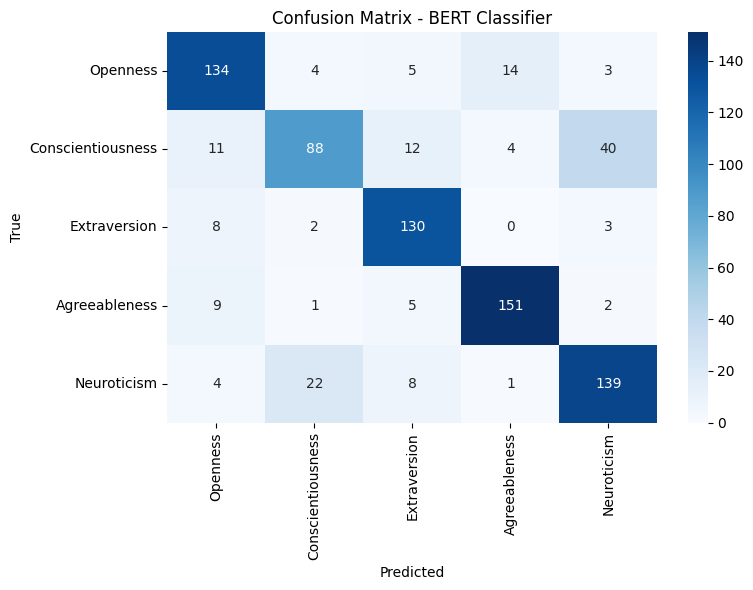

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

class_names = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - BERT Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


In [4]:
# Save the model and tokenizer
import os

model_path=os.path.join(os.getcwd(),'../models/BERT')

classification_model.save(model_path, save_format='tf')
tokenizer.save_pretrained(model_path)



INFO:tensorflow:Assets written to: /home/kjim/Documents/assignments/text_classification_AI/code/src/../models/BERT/assets


INFO:tensorflow:Assets written to: /home/kjim/Documents/assignments/text_classification_AI/code/src/../models/BERT/assets


('/home/kjim/Documents/assignments/text_classification_AI/code/src/../models/BERT/tokenizer_config.json',
 '/home/kjim/Documents/assignments/text_classification_AI/code/src/../models/BERT/special_tokens_map.json',
 '/home/kjim/Documents/assignments/text_classification_AI/code/src/../models/BERT/vocab.txt',
 '/home/kjim/Documents/assignments/text_classification_AI/code/src/../models/BERT/added_tokens.json')